<a href="https://colab.research.google.com/github/garretbassett/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/Garret_Bassett_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
import numpy as np
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  # time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
users[:10]

[User(purchased=True, time_on_site=538.8297121227506, mobile=True),
 User(purchased=True, time_on_site=523.636974607472, mobile=True),
 User(purchased=True, time_on_site=406.83880952065624, mobile=True),
 User(purchased=True, time_on_site=238.23367189280492, mobile=True),
 User(purchased=False, time_on_site=288.22299741203705, mobile=False),
 User(purchased=False, time_on_site=651.9919541612747, mobile=False),
 User(purchased=False, time_on_site=717.5032388870984, mobile=True),
 User(purchased=True, time_on_site=472.6006418410932, mobile=True),
 User(purchased=True, time_on_site=660.190072877449, mobile=True),
 User(purchased=False, time_on_site=397.9860425509189, mobile=False)]

In [0]:
print((random.random() < .1) + 5)

5


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,538.829712,True
1,True,523.636975,True
2,True,406.838810,True
3,True,238.233672,True
4,False,288.222997,False


In [0]:
user_data['time_on_site_min'] = user_data['time_on_site'] / 60 

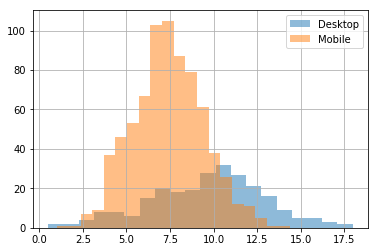

In [0]:
import matplotlib.pyplot as plt
# desktop_user_data.time_on_site.hist(alpha=.5)
# mobile_user_data.time_on_site.hist(alpha=.5)

user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5)
# Instead of making two separate dataframes, he just grouped by the Boolean. Much simpler.

plt.legend(['Desktop', 'Mobile']);

In [0]:
mobile_user_data[mobile_user_data['time_on_site'] < 0.0]

# Bruno had a couple of negative values - not sure why I don't

,purchased,time_on_site,mobile


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,23.586524039686253,93.31596448094501,94.1037219357429,109.86351970071382,120.15321267900413,124.56672197612107,126.10386708793396,126.98395550552613,139.99104481241693,142.40992632083783,143.65284246586396,145.86994149849528,149.2502079991355,152.30867499828707,153.71001245086023,155.39429192753386,156.73157550018266,158.17662942065988,159.307145620421,159.70360986265837,162.46055128130433,164.31042255287292,166.8104085036415,167.9114774293471,170.5676703232026,171.59727831814888,174.9492013957995,177.3401474509962,184.34509640579745,186.11659274496134,187.88423776004282,188.56339917554453,189.5596142405085,190.29902940711537,193.40286020686574,195.0063943659043,198.7046095313743,200.72891898596788,201.88336492602932,203.35565995894575,...,797.8954116294966,800.1589157943968,801.1539080317157,801.7155346262896,802.6674075121337,803.6825574740052,804.8743445821262,807.5671905547249,808.2534709469319,809.820988739694,810.4064142105847,814.8005454449899,817.0773256488262,818.5533256374265,820.1522911043674,820.4364117502446,820.9731154808903,821.8311699732735,830.3742678101676,832.9189281436305,834.3012803173597,834.4088350730308,839.983744408373,840.837892045477,849.2509274664089,856.2154103777765,865.1172303096052,866.7669913883085,869.8165854640924,881.433067261089,886.1483086229188,896.0298670455834,906.5167851621505,910.0732754093735,921.9854596094633,943.82762641552,986.0164713813881,1004.7048178968644,1016.7961913333775,1047.4059129657417
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,...,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,1
True,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0,1,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,0,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased']) # Why did I have to switch the variables?

purchased,False,True
time_on_site,,
"(22.563, 228.35]",37,19
"(228.35, 433.114]",353,383
"(433.114, 637.878]",400,559
"(637.878, 842.642]",83,150
"(842.642, 1047.406]",5,11


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(22.563, 228.35]",0.042141,0.016934
"(228.35, 433.114]",0.402050,0.341355
"(433.114, 637.878]",0.455581,0.498217
"(637.878, 842.642]",0.094533,0.133690
"(842.642, 1047.406]",0.005695,0.009804


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.566,0.396667
True,0.434,0.603333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')

purchased               False               True           
mobile                  False     True      False     True 
time_on_site                                               
(22.563, 228.35]     0.045936  0.040336  0.009217  0.018785
(228.35, 433.114]    0.254417  0.472269  0.211982  0.372376
(433.114, 637.878]   0.477032  0.445378  0.396313  0.522652
(637.878, 842.642]   0.204947  0.042017  0.336406  0.085083
(842.642, 1047.406]  0.017668  0.000000  0.046083  0.001105

## Police stop data

In [0]:
!unzip 'jb084sr9005_ma_statewide_2019_02_25.csv (2).zip'
!ls

Archive:  jb084sr9005_ma_statewide_2019_02_25.csv (2).zip
  inflating: share/data/opp-for-archive/ma_statewide_2019_02_25.csv  
'jb084sr9005_ma_statewide_2019_02_25.csv (2).zip'   sample_data
 jb084sr9005_nj_statewide_2019_02_25.csv.zip	    share


In [0]:
%%time
import pandas as pd

df = pd.read_csv('./share/data/opp-for-archive/ma_statewide_2019_02_25.csv', low_memory=False)
print(df.shape)
df.head()

(3416238, 23)
CPU times: user 15.7 s, sys: 1.78 s, total: 17.5 s
Wall time: 17.5 s


In [0]:
df.head()

,raw_row_number,date,location,county_name,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,contraband_alcohol,contraband_other,frisk_performed,search_conducted,search_basis,reason_for_stop,vehicle_type,vehicle_registration_state
0,1,2007-06-06,MIDDLEBOROUGH,Plymouth,33.0,white,male,vehicular,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,Speed,Passenger,MA
1,2,2007-06-07,SEEKONK,Bristol,36.0,white,male,vehicular,False,False,True,warning,False,False,False,False,False,False,True,other,NaN,Commercial,MA
2,3,2007-06-07,MEDFORD,Middlesex,56.0,white,female,vehicular,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,NaN,Passenger,MA
3,4,2007-06-07,MEDFORD,Middlesex,37.0,white,male,vehicular,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,NaN,Commercial,MA
4,5,2007-06-07,EVERETT,Middlesex,22.0,hispanic,female,vehicular,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,NaN,Commercial,MA


In [0]:
df.isna().sum()

raw_row_number                      0
date                                0
location                         6666
county_name                      6666
subject_age                    157828
subject_race                     1664
subject_sex                     15623
type                                0
arrest_made                       916
citation_issued                   916
warning_issued                    916
outcome                          6858
contraband_found              3359800
contraband_drugs              3359800
contraband_weapons            3359800
contraband_alcohol                  0
contraband_other                    0
frisk_performed                  2217
search_conducted                  410
search_basis                  3365209
reason_for_stop               1659589
vehicle_type                     4963
vehicle_registration_state       9814
dtype: int64

In [0]:
df.reason_for_stop.value_counts()

Speed                       1516016
SeatBelt                     173645
Speed,SeatBelt                52361
ChildRest                      8160
Speed,ChildRest                3638
SeatBelt,ChildRest             2322
Speed,SeatBelt,ChildRest        507
Name: reason_for_stop, dtype: int64

In [0]:
df.outcome.value_counts()

citation    2171283
warning     1146078
arrest        92019
Name: outcome, dtype: int64

In [0]:
pd.crosstab(df['reason_for_stop'], df['outcome'], normalize='columns')

outcome,arrest,citation,warning
reason_for_stop,,,
ChildRest,0.012785,0.005004,0.003090
SeatBelt,0.180274,0.112021,0.053079
"SeatBelt,ChildRest",0.001781,0.001649,0.000263
Speed,0.766758,0.842607,0.932354
"Speed,ChildRest",0.001872,0.002307,0.001338
"Speed,SeatBelt",0.036210,0.036052,0.009815
"Speed,SeatBelt,ChildRest",0.000320,0.000360,0.000060


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [53]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

#### DATA: https://openpolicing.stanford.edu/data/ ####

persons = pd.read_csv('https://raw.githubusercontent.com/garretbassett/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
persons = persons.drop('Unnamed: 0', axis=1)
print(persons.shape)
persons.head()

(1200, 3)


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


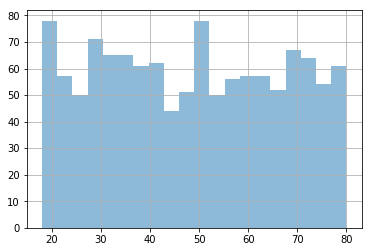

In [56]:
# First I wanted to visualize the distributions of each variable.
# Not much to see here; age is basically a uniform dist, weight tapers down
# across the board, as does exercise_time.

persons.age.hist(bins=20, alpha = 0.5)
plt.show()

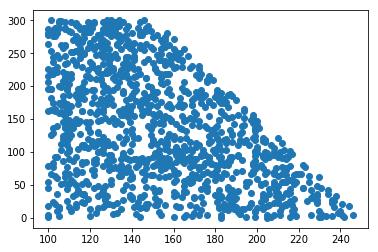

In [68]:
# How about some scatter plots?
# For age vs. exercise time, we get a fairly uniform distribution
#    before a steep dropoff at 60 yrs old.
# For weight vs. exercise time, we see a similar thing happening,
#    but the dropoff starts at 140 lbs and goes almost to 0 at 240.

plt.scatter(persons['weight'], persons['exercise_time'])
plt.show()

In [64]:
# Given the negative correlations between both age / weight and
# exercise time, I want to be able to separate the two if possible.
#
# The first thing I want to try is creating a new boolean variable called
# "is_old" and separating the data on that.

persons['is_old'] = persons['age'] > 65
persons['is_old'].value_counts()

persons['is_large'] = persons['weight'] > 200
persons['is_large'].value_counts()

False    1052
True      148
Name: is_large, dtype: int64

In [87]:
exercise_bins = pd.cut(persons['exercise_time'], 10)
pd.crosstab(exercise_bins, [persons['is_old'], persons['is_large']])

# Looks like people who are not old are more likely to have high exercise time,
# while old people's time peaks at the first quartile.

is_old         False       True       
is_large       False True  False True 
exercise_time                         
(-0.3, 30.0]      61    30    36    22
(30.0, 60.0]      61    28    27    13
(60.0, 90.0]      86    13    53    12
(90.0, 120.0]     77    22    48     5
(120.0, 150.0]    71     3    31     0
(150.0, 180.0]    93     0    25     0
(180.0, 210.0]    86     0     8     0
(210.0, 240.0]    95     0     3     0
(240.0, 270.0]   100     0     0     0
(270.0, 300.0]    91     0     0     0

is_old
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: weight, dtype: object

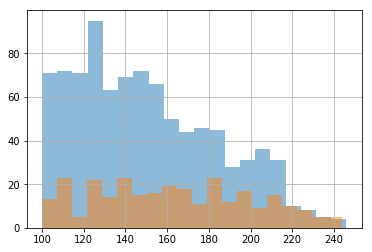

In [94]:
# print(persons[persons['is_old'] = True].value_counts())
persons.groupby('is_old').weight.hist(bins=20, alpha=0.5)

In [75]:
new_ct = pd.crosstab(exercise_bins, [persons['is_old'], persons['is_large']], normalize='columns')
type(new_ct)

pandas.core.frame.DataFrame

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data? 

**I'm not sure what this means. There were three variables, all of which were quantitative and discrete depending on how you look at it.**

2.  What are the relationships between the variables?

**Both age and weight are negatively correlated with exercise time.**

3.  Which relationships are "real", and which are spurious?

**I'm not sure. The weight distribution is pretty even for old people (>65 yrs), while it tapers down from 120 for young. I would think this results in an overstated effect of age on exercise.**

**I believe this is the case - when we account for that distinction, it is clear more old people exercise for longer in the non-heavy group.**

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)